In [1]:
import numpy as np
import pandas as pd
import random
import torch

Lets dynamically choose type of device to use for our computations. To run on your own GPU one needs to install pytorch and cuda-toolkit.

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [3]:
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650 Ti', major=7, minor=5, total_memory=4095MB, multi_processor_count=16)

Define the seed for reproductivity:

In [4]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 196
USE_SEED = True
if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

**Load the images and masks**

In [8]:
train_images = np.load("data/train_val_augmented/combined_images.npy")
train_masks = np.load("data/train_val_augmented/combined_masks.npy") 
test_images = np.load("data/test/test_images.npy")
test_masks = np.load("data/test/test_masks.npy")

In [9]:
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train masks shape:", train_masks.shape)
print("Test masks shape:", test_masks.shape)

Train images shape: (2400, 256, 256, 3)
Test images shape: (400, 256, 256, 3)
Train masks shape: (2400, 256, 256, 1)
Test masks shape: (400, 256, 256, 1)


**Standaritzation**

In [10]:
mean = np.mean(train_images, axis = (0,1,2)) / 255
std = np.std(train_images, axis = (0,1,2)) / 255

print("-----  NORMALIZATION VALUES  -----")
print(f"Mean (RGB): {mean}")
print(f"Standard Deviation (RGB): {std}")

-----  NORMALIZATION VALUES  -----
Mean (RGB): [0.56032691 0.32838803 0.24354746]
Standard Deviation (RGB): [0.31213819 0.23003688 0.1948857 ]


In [11]:
import torchvision
import torchvision.transforms as transforms

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize it between [0, 1]
    torchvision.transforms.Normalize(mean, std)  # Normalize the tensor using the provided mean and standard deviation
])

**Validation set**

In [13]:
from sklearn.model_selection import train_test_split

#Validation set (10%)
training_images, val_images, training_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42)

# Check shape of training images and masks
print("Training Images Shape:", training_images.shape)
print("Training Masks Shape:", training_masks.shape)

# Check shape of validation images and masks
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)

# Check length of training and validation sets
print("Number of Training Examples:", len(training_images))
print("Number of Validation Examples:", len(val_images))

Training Images Shape: (2160, 256, 256, 3)
Training Masks Shape: (2160, 256, 256, 1)
Validation Images Shape: (240, 256, 256, 3)
Validation Masks Shape: (240, 256, 256, 1)
Number of Training Examples: 2160
Number of Validation Examples: 240


In [14]:
from src.preprocess import KvasirDataset

# Create KvasirDataset objects for train, validation and test sets
train_dataset = KvasirDataset(images=train_images, masks=train_masks, transforms=transforms)
val_dataset = KvasirDataset(images=val_images,masks=val_masks, transforms=transforms)
test_dataset = KvasirDataset(images=test_images, masks=test_masks, transforms=transforms) 


**Define the model**

In [20]:
config = {}
config['name']='First_try'
config['epochs']=100
config['batch_size']=16
config['arch']='NestedUNet'
config['deep_supervision']=True
config['input_channels']=3
config['num_classes']=1
config['early_stopping']=5 # 5 epochs without improving the dice coefficient
#config['input_w']=128
#config['input_h']=128


In [21]:
from torch.utils.data import DataLoader

train_iterator = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=config['batch_size'])
val_iterator = DataLoader(val_dataset,batch_size=config['batch_size'])

In [22]:
from src.main import NestedUNet
from src.utils import count_parameters

model = NestedUNet(config)
print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 2,236,227 trainable parameters.


In [23]:
model = model.to(device)

In [24]:
from src.loss import DiceLoss
import torch.optim as optim

criterion = DiceLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) 


In [25]:
from src.train_val_test import train, evaluate
from collections import OrderedDict

log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('dice',[]),
    ('val_loss', []),
    ('val_iou', []),
    ('val_dice',[])
])

best_dice = 0
trigger = 0
for epoch in range(config['epochs']):
    print('Epoch [%d/%d]' % (epoch, config['epochs']))

    # train for one epoch
    train_log = train(config, model, train_iterator, criterion, optimizer, config['deep_supervision'], device)
    # evaluate on validation set
    val_log = evaluate(config, model, val_iterator, criterion, config['deep_supervision'], device)

    print('loss %.4f - iou %.4f - dice %.4f - val_loss %.4f - val_iou %.4f - val_dice %.4f'
          % (train_log['loss'], train_log['iou'], train_log['dice_coef'],val_log['loss'], val_log['iou'], val_log['dice_coef']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['dice'].append(train_log['dice_coef'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])
    log['val_dice'].append(val_log['dice_coef'])
    
    pd.DataFrame(log).to_csv('models/%s/log.csv' %
                             config['name'], index=False)

    trigger += 1

    if val_log['dice_coef'] > best_dice:
        torch.save(model.state_dict(), 'models/%s/model.pth' %
                   config['name'])
        best_dice = val_log['dice_coef']
        print("=> saved best model")
        trigger = 0

    # early stopping
    if config['early_stopping'] >= 0 and trigger >= config['early_stopping']:
        print("=> early stopping")
        break

    torch.cuda.empty_cache()

Epoch [0/100]


100%|███████████████████████████████████████████| 15/15 [01:45<00:00,  7.05s/it, loss=0.618, iou=0.149, dice_coef=0.404]


loss 0.6549 - iou 0.1536 - dice 0.3615 - val_loss 0.6175 - val_iou 0.1486 - val_dice 0.4043
=> saved best model
Epoch [1/100]


 17%|███████▋                                    | 26/150 [05:40<26:54, 13.02s/it, loss=0.625, iou=0.158, dice_coef=0.4]

KeyboardInterrupt: 

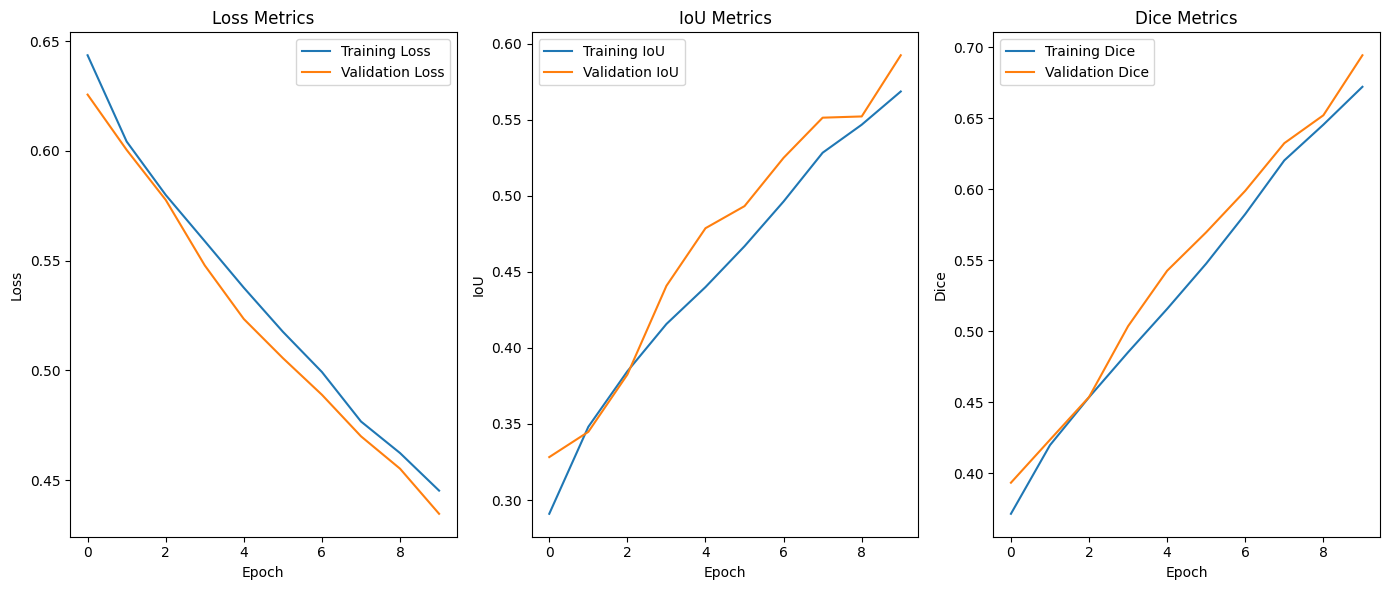

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('models/First_try/log.csv')

# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# Plot the loss features in the first subplot
ax1.plot(df['epoch'], df['loss'], label='Training Loss')
ax1.plot(df['epoch'], df['val_loss'], label='Validation Loss')
ax1.set_title('Loss Metrics')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the IoU and Dice metrics in the second subplot
ax2.plot(df['epoch'], df['iou'], label='Training IoU')
ax2.plot(df['epoch'], df['val_iou'], label='Validation IoU')
ax2.set_title('IoU Metrics')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('IoU')
ax2.legend()

ax3.plot(df['epoch'], df['dice'], label='Training Dice')
ax3.plot(df['epoch'], df['val_dice'], label='Validation Dice')
ax3.set_title('Dice Metrics')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Dice')
ax3.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
test_log = evaluate(config, model, test_iterator, criterion, config['deep_supervision'], device)

print('test_loss %.4f - test_iou %.4f - test_dice %.4f'
          % (test_log['loss'], test_log['iou'], test_log['dice_coef']))

100%|███████████████████████████████████████████| 75/75 [00:08<00:00,  8.46it/s, loss=0.451, iou=0.555, dice_coef=0.669]

test_loss 0.4513 - test_iou 0.5550 - test_dice 0.6693
